In [1]:
import warnings
warnings.filterwarnings('ignore')
#load the model and the modules
import keras
from keras import models, layers
from keras.activations import relu, softmax
from keras.applications import VGG19
from keras.models import Sequential, load_model, Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Dense, Flatten
import matplotlib.pyplot as plt
import sys
from PIL import Image
sys.modules['Image'] = Image

Using TensorFlow backend.


### Image generators

#### The training dataset and the validation dataset should be in seperated folders. In each of the folders  there should be a different subfolders for each of the classes (individuals).  For example if training a model to classify 3 classes the directory of the training pictures should be:
    PATH/TO/Training_data/
                         Class_A/
                                 Class_A_image1.jpg
                                 Class_A_image2.jpg
                                 Class_A_image3.jpg
                                 .
                                 .
                                 .
                                 
                         Class_B/
                                 Class_B_image1.jpg
                                 .
                                 .
                                 .
                         Class_C/
                                 Class_C_image1.jpg
                                 .
                                 .
                                 .

In [2]:
            # We use a data generator to pass the images through the convolutional neural network and and apply
#rotation and zoom transformations to the images

train_data = ImageDataGenerator(
        rotation_range=40,
        zoom_range=0.2,
        rescale = 1./255)

train_generator = train_data.flow_from_directory(
    directory=r"/mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Data/Train",
    #directory=r"/home/andre/Desktop/All_birds/Data/35_Validation_corrected/Train_AGM",
        #directory=r"/mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Data/Train_AGM",
        #directory=r"/PATH/TO/Training_data_set
        target_size=(224, 224),
        batch_size=8,
        shuffle=True)

Found 27000 images belonging to 30 classes.


In [3]:
#defining the validation data generator
val_data = ImageDataGenerator(rescale = 1./255)
                                 
val_generator = val_data.flow_from_directory(
    directory=r"/mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Data/Train",
    #directory=r"/home/andre/Desktop/All_birds/Data/35_Validation_corrected/Validation_AGM",
        #directory=r"/mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Data/Validation_AGM",
        #directory=r"/PATH/TO/Validation_data_set
        target_size=(224, 224),
        batch_size=8,
        shuffle=True)

Found 27000 images belonging to 30 classes.


### Convolutional neural network

In [4]:
#load the pre-trained VGG19 from keras
vgg19 = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = vgg19.layers[-1].output
#add dropout and the full connected layers
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
#add a dense layer with a value equal to the number of classes
predictors = Dense(30, activation='softmax')(x)
# Create the model
vgg19model = Model(input=vgg19.input, output=predictors)

In [5]:
#check the model
vgg19model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Model training

In [8]:
# define where to save the model after each epoch
filepath = "PATH/TO/Save_model.h5"
# add a critera to save only if there was an improvement in the model comparing
# to the previous epoch (in this caset the model is saved if there was a decrease in the loss value)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# stop training if there is no improvement in model for 3 consecutives epochs.
early_stopping_monitor = EarlyStopping(patience=3)
callbacks_list = [checkpoint, early_stopping_monitor]

In [9]:
# Compile the model
vgg19model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5),
              metrics=['acc'])

In [9]:
#train the model
batch_size=8
model.fit_generator(
        train_generator,
        steps_per_epoch=27000//batch_size,#number of pictures divided by the batch size
        epochs=30,
        validation_data=val_generator,
        validation_steps= 3000// batch_size,
        callbacks=callbacks_list)

Epoch 1/30
3375/3375 [==============================] - 934s 277ms/step - loss: 3.3986 - acc: 0.0378 - val_loss: 3.3612 - val_acc: 0.0571

Epoch 00001: val_loss improved from inf to 3.36124, saving model to /mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Models/VGG19_30ind_d5_at_dense_NoAGM.h5
Epoch 2/30
3375/3375 [==============================] - 666s 197ms/step - loss: 3.0958 - acc: 0.1035 - val_loss: 2.5839 - val_acc: 0.2701

Epoch 00002: val_loss improved from 3.36124 to 2.58393, saving model to /mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Models/VGG19_30ind_d5_at_dense_NoAGM.h5
Epoch 3/30
3375/3375 [==============================] - 699s 207ms/step - loss: 1.4534 - acc: 0.5919 - val_loss: 0.9525 - val_acc: 0.7634

Epoch 00003: val_loss improved from 2.58393 to 0.95255, saving model to /mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Models/VGG19_30ind_d5_at_dense_NoAGM.h5
Epoch 4/30
3375/3375 [==============================] - 700s 2

#### If you want to continue training the model with a diferent optimizer or learning rate load the last saved model and compile the model again before training


In [13]:
#load the model
model=load_model("PATH/TO/Save_model.h5")

# Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer=SGD(lr=1e-6),
             metrics=['acc'])
#train the model
batch_size=8
model_history_2=vgg19model.fit_generator(
        train_generator,
        steps_per_epoch=162000//batch_size,
        epochs=30,
        validation_data=val_generator,
        validation_steps= 18000// batch_size,
        callbacks=callbacks_list)

Epoch 1/30
3375/3375 [==============================] - 624s 185ms/step - loss: 0.1948 - acc: 0.9550 - val_loss: 0.4389 - val_acc: 0.9144

Epoch 00001: val_loss improved from 0.45985 to 0.43888, saving model to /mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Models/VGG19_30ind_d5_at_dense_NoAGM.h5
Epoch 2/30
3375/3375 [==============================] - 626s 186ms/step - loss: 0.1794 - acc: 0.9590 - val_loss: 0.4296 - val_acc: 0.9179

Epoch 00002: val_loss improved from 0.43888 to 0.42955, saving model to /mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Models/VGG19_30ind_d5_at_dense_NoAGM.h5
Epoch 3/30
3375/3375 [==============================] - 656s 194ms/step - loss: 0.1761 - acc: 0.9596 - val_loss: 0.4300 - val_acc: 0.9221

Epoch 00003: val_loss did not improve from 0.42955
Epoch 4/30
3375/3375 [==============================] - 655s 194ms/step - loss: 0.1759 - acc: 0.9602 - val_loss: 0.4269 - val_acc: 0.9230

Epoch 00004: val_loss improved from 0.42955

In [12]:
# Train_loss=[1.66, 0.2426, 0.1421, 0.1296, 0.1247, 0.1236, 0.1202, 0.1193, 0.1185, 0.1163 ,0.1167,0.1166, 0.1151, 0.1145]
# Val_loss=[0.6277, 0.5178, 0.5557, 0.536, 0.5276, 0.5263, 0.5203, 0.5185, 0.5173, 0.5173, 0.5159, 0.5155, 0.5159, 0.5127]

# Train_acc=[0.5447, 0.9435, 0.9647, 0.9679, 0.9691, 0.9693, 0.97, 0.9702, 0.9706, 0.9711, 0.971, 0.9709, 0.9712, 0.9714]
# Val_acc=[0.8609, 0.8812, 0.8992, 0.9041, 0.907, 0.9075, 0.9087, 0.9089, 0.9093, 0.9096, 0.909, 0.9093, 0.9093, 0.903]

# Train_loss=[3.3986, 3.0958, 1.4534, 0.5561, 0.3633, 0.2833, 0.2371, 0.1948, 0.1794, 0.1761, 0.1759, 0.1674, 0.1629, 0.1654, 0.1639, 0.1619, 0.1614, 0.16, 0.1641, 0.1592, 0.1591]
# Val_loss=[3.3612, 2.5839, 0.9525, 0.6917, 0.6823, 0.5099, 0.4599, 0.4389, 0.4296, 0.43, 0.4269, 0.4249, 0.4262, 0.4241, 0.4218, 0.4296, 0.426, 0.4211, 0.4202, 0.4349, 0.4153]

# Train_acc=[0.0378, 0.1035, 0.5919, 0.8653, 0.9183, 0.9366, 0.9473, 0.955, 0.959, 0.9596, 0.9602, 0.9624, 0.9621, 0.9626, 0.9622, 0.9634, 0.9633, 0.9638, 0.9632, 0.964, 0.9643]
# Val_acc=[0.0571, 0.2701, 0.7634, 0.8451, 0.8473, 0.8976, 0.9073, 0.9144, 0.9179, 0.9221, 0.923, 0.9226, 0.9236, 0.9235, 0.9231, 0.9231, 0.9233, 0.9236, 0.9231, 0.922, 0.9235]

# fig=plt.figure(figsize=(15,5))
# columns = 2
# rows = 1

# fig.add_subplot(rows, columns, 1)
# plt.plot(Train_loss)
# plt.plot(Val_loss)
# plt.title('loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')

# fig.add_subplot(rows, columns, 2)
# plt.plot(Train_acc)
# plt.plot(Val_acc)
# plt.title('accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

#### After training its possible to visualize the training process and check for overfitting.

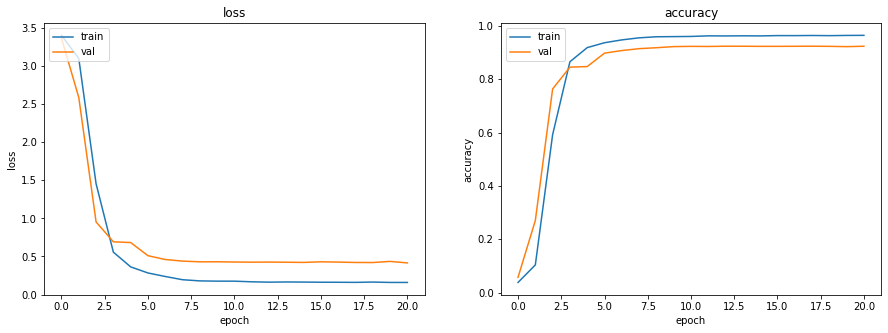

In [17]:
#size of the plots
fig=plt.figure(figsize=(15,5))
columns = 2
rows = 1

#plot loss
fig.add_subplot(rows, columns, 1)
plt.plot(model_history.history['loss']+ model_history_2.history['loss']) 
plt.plot(model_history.history['val_loss']+ model_history_2.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

#plot accuracy
fig.add_subplot(rows, columns, 2)
plt.plot(model_history.history['acc']+ model_history_2.history['acc'])
plt.plot(model_history.history['val_acc']+ model_history_2.history['val_acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model Generalization

#### in order to evaluate the model the model generalization capability you can see how the model performs when exposed to images collected in diferent conditions.
#### Here this testing dataset will be loaded using image generators like the training and the validation dataset

In [2]:
#after 
#model=load_model("PATH/TO/Save_model.h5")
#model=load_model("/mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Models/VGG19_30ind_d5_at_dense.h5")

#### Close

In [17]:
val_sony_datagen1 = ImageDataGenerator(rescale = 1./255)
val_sony_datagen = val_sony_datagen1.flow_from_directory(
        directory=r"/mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Data/Generalization/Close",
        target_size=(224, 224),
        batch_size=500,
        shuffle=False)

x_batch, y_batch=next(val_sony_datagen)

acertou=[]
nao_acertou=[]
for i in range(0,len(x_batch)):
    a=np.expand_dims(x_batch[i], axis=0)
    result=model.predict(a)
    if np.where(y_batch[i] == np.amax(y_batch[i]))[0][0]+1==np.where(result == np.amax(result))[1][0]+1:
        acertou.append(i)
    else:
        nao_acertou.append(i)
print(len(acertou)/(len(nao_acertou)+len(acertou)))


Found 95 images belonging to 30 classes.
0.9263157894736842


#### Far

In [4]:
val_sony_datagen1 = ImageDataGenerator(rescale = 1./255)
val_sony_datagen = val_sony_datagen1.flow_from_directory(
        directory=r"/mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Data/Generalization/Far",
        target_size=(224, 224),
        batch_size=500,
        shuffle=False)

x_batch, y_batch=next(val_sony_datagen)

acertou=[]
nao_acertou=[]
for i in range(0,len(x_batch)):
    a=np.expand_dims(x_batch[i], axis=0)
    result=model.predict(a)
    if np.where(y_batch[i] == np.amax(y_batch[i]))[0][0]+1==np.where(result == np.amax(result))[1][0]+1:
        acertou.append(i)
    else:
        nao_acertou.append(i)
print(len(acertou)/(len(nao_acertou)+len(acertou)))


Found 72 images belonging to 30 classes.
0.9722222222222222


#### Ground

In [5]:
val_sony_datagen1 = ImageDataGenerator(rescale = 1./255)
val_sony_datagen = val_sony_datagen1.flow_from_directory(
        directory=r"/mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Data/Generalization/Ground",
        target_size=(224, 224),
        batch_size=500,
        shuffle=False)

x_batch, y_batch=next(val_sony_datagen)

acertou=[]
nao_acertou=[]
for i in range(0,len(x_batch)):
    a=np.expand_dims(x_batch[i], axis=0)
    result=model.predict(a)
    if np.where(y_batch[i] == np.amax(y_batch[i]))[0][0]+1==np.where(result == np.amax(result))[1][0]+1:
        acertou.append(i)
    else:
        nao_acertou.append(i)
print(len(acertou)/(len(nao_acertou)+len(acertou)))

Found 90 images belonging to 30 classes.
0.9444444444444444


#### Top

In [6]:
val_sony_datagen1 = ImageDataGenerator(rescale = 1./255)
val_sony_datagen = val_sony_datagen1.flow_from_directory(
        directory=r"/mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Data/Generalization/Top",
        target_size=(224, 224),
        batch_size=500,
        shuffle=False)

x_batch, y_batch=next(val_sony_datagen)

acertou=[]
nao_acertou=[]
for i in range(0,len(x_batch)):
    a=np.expand_dims(x_batch[i], axis=0)
    result=model.predict(a)
    if np.where(y_batch[i] == np.amax(y_batch[i]))[0][0]+1==np.where(result == np.amax(result))[1][0]+1:
        acertou.append(i)
    else:
        nao_acertou.append(i)
print(len(acertou)/(len(nao_acertou)+len(acertou)))


Found 83 images belonging to 30 classes.
0.9156626506024096


#### Two months

In [7]:
val_sony_datagen1 = ImageDataGenerator(rescale = 1./255)
val_sony_datagen = val_sony_datagen1.flow_from_directory(
        directory=r"/mnt/ubuntu_disk/Ubuntu_drive/Analises_30052019/30_individuals/Data/Generalization/Two_months",
        target_size=(224, 224),
        batch_size=500,
        shuffle=False)

x_batch, y_batch=next(val_sony_datagen)

acertou=[]
nao_acertou=[]
for i in range(0,len(x_batch)):
    a=np.expand_dims(x_batch[i], axis=0)
    result=model.predict(a)
    if np.where(y_batch[i] == np.amax(y_batch[i]))[0][0]+1==np.where(result == np.amax(result))[1][0]+1:
        acertou.append(i)
    else:
        nao_acertou.append(i)
print(len(acertou)/(len(nao_acertou)+len(acertou)))


Found 59 images belonging to 30 classes.
0.0847457627118644


### Rotations top

In [5]:
Original_data_setTrain="/home/andre/Desktop/All_birds/Data/Generalization/30/10days"
imagePathsTrain = sorted(list(paths.list_images(Original_data_setTrain)))
from scipy.stats import entropy
val_sony_datagen1 = ImageDataGenerator(rescale = 1./255)
val_sony_datagen = val_sony_datagen1.flow_from_directory(
        directory=r"/home/andre/Desktop/All_birds/Data/Generalization/30/10days",
        target_size=(224, 224),
        batch_size=500,
        shuffle=False)

x_batch, y_batch=next(val_sony_datagen)

acertou=[]
nao_acertou=[]
for i in range(0,len(x_batch)):
    a=np.expand_dims(x_batch[i], axis=0)
    result=model.predict(a)
    if np.where(y_batch[i] == np.amax(y_batch[i]))[0][0]+1==np.where(result == np.amax(result))[1][0]+1:
        acertou.append(i)
        #print(entropy(result[0]))
        print(print(imagePathsTrain[i]))
    else:
        nao_acertou.append(i)
        #print(imagePathsTrain[i])
        
print(len(acertou)/(len(nao_acertou)+len(acertou)))

Found 24 images belonging to 30 classes.
/home/andre/Desktop/All_birds/Data/Generalization/30/10days/011016B1FB/011016B1FB_0923_01_131218_1.jpg
None
/home/andre/Desktop/All_birds/Data/Generalization/30/10days/011016B1FB/011016B1FB_0927_01_131218_1.jpg
None
/home/andre/Desktop/All_birds/Data/Generalization/30/10days/011016B1FB/011016B1FB_1005_01_131218_16.jpg
None
/home/andre/Desktop/All_birds/Data/Generalization/30/10days/011016BE08/011016BE08_05_0038_towmonths28_12_2018.jpg
None
/home/andre/Desktop/All_birds/Data/Generalization/30/10days/011016BE08/011016BE08_05_0045_towmonths28_12_2018.jpg
None
/home/andre/Desktop/All_birds/Data/Generalization/30/10days/011016C8B0/011016C8B0_05_0213_towmonths28_12_2018.jpg
None
/home/andre/Desktop/All_birds/Data/Generalization/30/10days/0417D30D92/0417D30D92_0213_13_131218_8.jpg
None
/home/andre/Desktop/All_birds/Data/Generalization/30/10days/0417D30D92/0417D30D92_0839_12_131218_31.jpg
None
/home/andre/Desktop/All_birds/Data/Generalization/30/10days/

### Validation per Bird

In [ ]:
%%capture
from shutil import copyfile
from imutils import paths
import random
import os
results=[]
for Tag in Tags:
    Original_data_setTrain="/home/andre/Desktop/All_birds/Data/Dataset/Validation/"+Tag
    outputfolderTrain="/home/andre/Desktop/All_birds/Data/Dataset/Validationtest/"+Tag+"/"
    imagePathsTrain = sorted(list(paths.list_images(Original_data_setTrain)))
    random.shuffle(imagePathsTrain)
    imagePathsTrain=imagePathsTrain[0:100]
    for imagePath in imagePathsTrain:
        name=imagePath.split(os.path.sep)[-1]
        name=outputfolderTrain+name
        copyfile(imagePath, name)
        val_sony_datagen1 = ImageDataGenerator(rescale = 1./255,
                                        #preprocessing_function=preprocess
                                        #rotation_range=40,
                                    #shear_range = 0.2,
                                    #zoom_range = 0.2
                                    #horizontal_flip = True)
                                        )
    val_sony_datagen = val_sony_datagen1.flow_from_directory(
            directory=r"/home/andre/Desktop/All_birds/Data/Dataset/Validationtest",
            target_size=(224, 224),
            batch_size=100,
            shuffle=False)

    x_batch, y_batch = next(val_sony_datagen)
    acertou=[]
    nao_acertou=[]
    for i in range(0,len(x_batch)):
        #print("pred:")
        a=np.expand_dims(x_batch[i], axis=0)
        result=model.predict(a)
            #print(np.where(result == np.amax(result))[1][0]+1)
            #print(result)
            #print("true:")
            #print(np.where(val_sonny_labels[i] == np.amax(val_sonny_labels[i]))[0][0]+1)
        if np.where(y_batch[i] == np.amax(y_batch[i]))[0][0]+1==np.where(result == np.amax(result))[1][0]+1:
            acertou.append(i)
        else:
            nao_acertou.append(i)
    #print(Tag)
    #print(len(acertou)/(len(nao_acertou)+len(acertou)))
    results.append([Tag, len(acertou)/(len(nao_acertou)+len(acertou))])
    
    imagePathsValidationtest =sorted(list(paths.list_images(outputfolderTrain)))
    
    for imagePath in imagePathsValidationtest:
        os.remove(imagePath)